In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [2]:
root = './CIFAR10_Syn_Coreset'
ipc = 1

### CIFAR10 Coreset

In [3]:
class CIFAR10_Coreset(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [4]:
index_file = pd.read_csv(f'./coreset_index/ipc{ipc}_idx.csv')
index_file

,image_path,label
0,./CIFAR10_Syn_Coreset/ipc1/airplane/d10bb63d-c...,0
1,./CIFAR10_Syn_Coreset/ipc1/automobile/5a676437...,1
2,./CIFAR10_Syn_Coreset/ipc1/bird/d1a9436e-bd72-...,2
3,./CIFAR10_Syn_Coreset/ipc1/cat/a6697786-bf93-4...,3
4,./CIFAR10_Syn_Coreset/ipc1/deer/8f69fc13-de00-...,4
5,./CIFAR10_Syn_Coreset/ipc1/dog/a71a829e-da91-4...,5
6,./CIFAR10_Syn_Coreset/ipc1/frog/527902c5-dd52-...,6
7,./CIFAR10_Syn_Coreset/ipc1/horse/d0d05541-bc54...,7
8,./CIFAR10_Syn_Coreset/ipc1/ship/73af5334-b8cf-...,8
9,./CIFAR10_Syn_Coreset/ipc1/truck/f88d5e78-3c0d...,9


In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_coreset_train = CIFAR10_Coreset(index_file, transform)

cifar10_root = '../cifar10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [6]:
batch_size = 1 
train_data_loader, test_data_loader = get_data_loaders(cifar10_coreset_train, cifar10_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [8]:
import os

model_name = 'ConvNetD3'
model_path = f'./model_weight/ipc{ipc}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100)

Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 34.11it/s, loss=3.16]


epoch: 1 done, loss: 2.7520549297332764
Acc: 0.1328
[0.001]


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 216.00it/s, loss=2.18]

epoch: 2 done, loss: 1.7107954025268555


Acc: 0.1493
[0.001]


Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 143.09it/s, loss=0.78]

epoch: 3 done, loss: 1.2298513650894165


Acc: 0.1707
[0.001]


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 139.68it/s, loss=1.02]

epoch: 4 done, loss: 0.9143363237380981


Acc: 0.1764
[0.001]


Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 123.73it/s, loss=0.848]

epoch: 5 done, loss: 0.5179044604301453


Acc: 0.1867
[0.001]


Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 148.56it/s, loss=0.201]

epoch: 6 done, loss: 0.2808980941772461


Acc: 0.1895
[0.001]


Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 147.48it/s, loss=0.269]

epoch: 7 done, loss: 0.31556156277656555


Acc: 0.1939
[0.0001]


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 154.82it/s, loss=0.649]

epoch: 8 done, loss: 0.7105767130851746


Acc: 0.1937
[0.0001]


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 137.25it/s, loss=0.152]

epoch: 9 done, loss: 0.6179584264755249


Acc: 0.196
[0.0001]


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 151.90it/s, loss=0.31]

epoch: 10 done, loss: 0.5777752995491028


Acc: 0.197
[0.0001]


Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 147.94it/s, loss=0.291]

epoch: 11 done, loss: 0.21516075730323792


Acc: 0.1968
[1e-05]


Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 145.57it/s, loss=0.0871]

epoch: 12 done, loss: 0.23577772080898285


Acc: 0.1971
[1e-05]


Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 137.69it/s, loss=0.204]

epoch: 13 done, loss: 0.22186298668384552


Acc: 0.197
[1e-05]


Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 143.49it/s, loss=0.279]

epoch: 14 done, loss: 0.1844642162322998


Acc: 0.1971
[1e-05]


Epoch 15: 100%|██████████| 10/10 [00:00<00:00, 134.63it/s, loss=0.148]

epoch: 15 done, loss: 0.5498915910720825


Acc: 0.1971
[1.0000000000000002e-06]


Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 132.90it/s, loss=0.277]

epoch: 16 done, loss: 0.6040453314781189


Acc: 0.1972
[1.0000000000000002e-06]


Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 128.57it/s, loss=0.156]

epoch: 17 done, loss: 0.5026658773422241


Acc: 0.1972
[1.0000000000000002e-06]


Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 145.06it/s, loss=3.22]

epoch: 18 done, loss: 0.5667888522148132


Acc: 0.1974
[1.0000000000000002e-06]


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 145.17it/s, loss=0.51]

epoch: 19 done, loss: 0.2328805774450302


Acc: 0.1974
[1.0000000000000002e-06]


Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 131.93it/s, loss=0.156]

epoch: 20 done, loss: 0.5425491333007812


Acc: 0.1974
[1.0000000000000002e-06]


Epoch 21: 100%|██████████| 10/10 [00:00<00:00, 162.88it/s, loss=0.12]

epoch: 21 done, loss: 0.19616104662418365


Acc: 0.1975
[1.0000000000000002e-06]


Epoch 22: 100%|██████████| 10/10 [00:00<00:00, 143.17it/s, loss=0.156]

epoch: 22 done, loss: 0.24659283459186554


Acc: 0.1974
[1.0000000000000002e-06]


Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 169.95it/s, loss=0.154]

epoch: 23 done, loss: 0.544759213924408


Acc: 0.1974
[1.0000000000000002e-06]


Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 136.80it/s, loss=0.0861]

epoch: 24 done, loss: 0.2722301185131073


Acc: 0.1975
[1.0000000000000002e-06]


Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 169.82it/s, loss=0.156]

epoch: 25 done, loss: 0.5520886778831482


Acc: 0.1975
[1.0000000000000002e-06]


Epoch 26: 100%|██████████| 10/10 [00:00<00:00, 153.61it/s, loss=0.12]

epoch: 26 done, loss: 0.2399352341890335


Acc: 0.1975
[1.0000000000000002e-06]


Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 158.02it/s, loss=0.171]

epoch: 27 done, loss: 0.5037365555763245


Acc: 0.1974
[1.0000000000000002e-06]


Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 155.26it/s, loss=0.271]

epoch: 28 done, loss: 0.5071682929992676


Acc: 0.1976
[1.0000000000000002e-06]


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 184.20it/s, loss=0.0861]

epoch: 29 done, loss: 0.1994715929031372


Acc: 0.1977
[1.0000000000000002e-06]


Epoch 30: 100%|██████████| 10/10 [00:00<00:00, 152.55it/s, loss=0.12]

epoch: 30 done, loss: 0.17718851566314697


Acc: 0.1977
[1.0000000000000002e-06]


Epoch 31: 100%|██████████| 10/10 [00:00<00:00, 156.07it/s, loss=0.148]

epoch: 31 done, loss: 0.22640161216259003


Acc: 0.1976
[1.0000000000000002e-06]


Epoch 32: 100%|██████████| 10/10 [00:00<00:00, 175.22it/s, loss=0.274]

epoch: 32 done, loss: 0.46688351035118103


Acc: 0.1976
[1.0000000000000002e-06]


Epoch 33: 100%|██████████| 10/10 [00:00<00:00, 136.05it/s, loss=0.201]

epoch: 33 done, loss: 0.20362424850463867


Acc: 0.1976
[1.0000000000000002e-06]


Epoch 34: 100%|██████████| 10/10 [00:00<00:00, 160.63it/s, loss=0.448]

epoch: 34 done, loss: 0.2602829933166504


Acc: 0.1976
[1.0000000000000002e-06]


Epoch 35: 100%|██████████| 10/10 [00:00<00:00, 120.72it/s, loss=0.153]

epoch: 35 done, loss: 0.44875437021255493


Acc: 0.1976
[1.0000000000000002e-06]


Epoch 36: 100%|██████████| 10/10 [00:00<00:00, 201.57it/s, loss=0.17]

epoch: 36 done, loss: 0.5043147802352905


Acc: 0.1975
[1.0000000000000002e-06]


Epoch 37: 100%|██████████| 10/10 [00:00<00:00, 224.21it/s, loss=0.222]

epoch: 37 done, loss: 0.5125760436058044


Acc: 0.1974
[1.0000000000000002e-06]


Epoch 38: 100%|██████████| 10/10 [00:00<00:00, 207.54it/s, loss=0.17]

epoch: 38 done, loss: 0.5534562468528748


Acc: 0.1975
[1.0000000000000002e-06]


Epoch 39: 100%|██████████| 10/10 [00:00<00:00, 227.24it/s, loss=0.232]

epoch: 39 done, loss: 0.1951296031475067


Acc: 0.1975
[1.0000000000000002e-06]


Epoch 40: 100%|██████████| 10/10 [00:00<00:00, 223.87it/s, loss=0.269]

epoch: 40 done, loss: 0.23891477286815643


Acc: 0.1976
[1.0000000000000002e-06]


Epoch 41: 100%|██████████| 10/10 [00:00<00:00, 200.93it/s, loss=0.508]

epoch: 41 done, loss: 0.23504941165447235


Acc: 0.1977
[1.0000000000000002e-06]


Epoch 42: 100%|██████████| 10/10 [00:00<00:00, 205.66it/s, loss=0.147]

epoch: 42 done, loss: 0.5200680494308472


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 43: 100%|██████████| 10/10 [00:00<00:00, 228.37it/s, loss=3.17]

epoch: 43 done, loss: 0.5289357304573059


Acc: 0.1977
[1.0000000000000002e-06]


Epoch 44: 100%|██████████| 10/10 [00:00<00:00, 208.96it/s, loss=0.112]

epoch: 44 done, loss: 0.5108677744865417


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 45: 100%|██████████| 10/10 [00:00<00:00, 194.77it/s, loss=0.507]

epoch: 45 done, loss: 0.24250078201293945


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 46: 100%|██████████| 10/10 [00:00<00:00, 220.87it/s, loss=0.274]

epoch: 46 done, loss: 0.5326296091079712


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 47: 100%|██████████| 10/10 [00:00<00:00, 161.05it/s, loss=0.0858]


epoch: 47 done, loss: 0.2377079725265503
Acc: 0.1978
[1.0000000000000002e-06]


Epoch 48: 100%|██████████| 10/10 [00:00<00:00, 189.53it/s, loss=0.267]

epoch: 48 done, loss: 0.5219420790672302


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 204.15it/s, loss=0.112]

epoch: 49 done, loss: 0.20925211906433105


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 50: 100%|██████████| 10/10 [00:00<00:00, 197.01it/s, loss=0.169]

epoch: 50 done, loss: 0.5521182417869568


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 51: 100%|██████████| 10/10 [00:00<00:00, 211.08it/s, loss=0.148]

epoch: 51 done, loss: 0.1770583689212799


Acc: 0.198
[1.0000000000000002e-06]


Epoch 52: 100%|██████████| 10/10 [00:00<00:00, 191.29it/s, loss=0.134]

epoch: 52 done, loss: 0.5812954902648926


Acc: 0.198
[1.0000000000000002e-06]


Epoch 53: 100%|██████████| 10/10 [00:00<00:00, 225.84it/s, loss=0.23]

epoch: 53 done, loss: 0.5645908117294312


Acc: 0.198
[1.0000000000000002e-06]


Epoch 54: 100%|██████████| 10/10 [00:00<00:00, 237.12it/s, loss=0.438]

epoch: 54 done, loss: 0.22672557830810547


Acc: 0.198
[1.0000000000000002e-06]


Epoch 55: 100%|██████████| 10/10 [00:00<00:00, 229.47it/s, loss=0.23]

epoch: 55 done, loss: 0.19145359098911285


Acc: 0.198
[1.0000000000000002e-06]


Epoch 56: 100%|██████████| 10/10 [00:00<00:00, 220.03it/s, loss=0.23]

epoch: 56 done, loss: 0.20203177630901337


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 57: 100%|██████████| 10/10 [00:00<00:00, 243.00it/s, loss=0.0947]

epoch: 57 done, loss: 0.4415774345397949


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 58: 100%|██████████| 10/10 [00:00<00:00, 270.26it/s, loss=0.169]

epoch: 58 done, loss: 0.22154581546783447


Acc: 0.198
[1.0000000000000002e-06]


Epoch 59: 100%|██████████| 10/10 [00:00<00:00, 256.92it/s, loss=0.153]

epoch: 59 done, loss: 0.5202974081039429


Acc: 0.198
[1.0000000000000002e-06]


Epoch 60: 100%|██████████| 10/10 [00:00<00:00, 250.63it/s, loss=3.13]

epoch: 60 done, loss: 0.5383285880088806


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 61: 100%|██████████| 10/10 [00:00<00:00, 239.86it/s, loss=0.151]

epoch: 61 done, loss: 0.5244797468185425


Acc: 0.198
[1.0000000000000002e-06]


Epoch 62: 100%|██████████| 10/10 [00:00<00:00, 230.18it/s, loss=0.119]

epoch: 62 done, loss: 0.2101660966873169


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 63: 100%|██████████| 10/10 [00:00<00:00, 275.90it/s, loss=0.134]

epoch: 63 done, loss: 0.17618919909000397


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 64: 100%|██████████| 10/10 [00:00<00:00, 258.82it/s, loss=0.145]

epoch: 64 done, loss: 0.17982801795005798


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 65: 100%|██████████| 10/10 [00:00<00:00, 266.84it/s, loss=0.229]

epoch: 65 done, loss: 0.5241841673851013


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 66: 100%|██████████| 10/10 [00:00<00:00, 262.93it/s, loss=0.0944]

epoch: 66 done, loss: 0.5137516856193542


Acc: 0.198
[1.0000000000000002e-06]


Epoch 67: 100%|██████████| 10/10 [00:00<00:00, 257.71it/s, loss=0.151]

epoch: 67 done, loss: 0.21554580330848694


Acc: 0.198
[1.0000000000000002e-06]


Epoch 68: 100%|██████████| 10/10 [00:00<00:00, 264.29it/s, loss=0.22]

epoch: 68 done, loss: 0.13590572774410248


Acc: 0.198
[1.0000000000000002e-06]


Epoch 69: 100%|██████████| 10/10 [00:00<00:00, 266.23it/s, loss=0.265]

epoch: 69 done, loss: 0.23485758900642395


Acc: 0.198
[1.0000000000000002e-06]


Epoch 70: 100%|██████████| 10/10 [00:00<00:00, 254.87it/s, loss=0.111]

epoch: 70 done, loss: 0.18362930417060852


Acc: 0.198
[1.0000000000000002e-06]


Epoch 71: 100%|██████████| 10/10 [00:00<00:00, 260.84it/s, loss=0.265]

epoch: 71 done, loss: 0.16054081916809082


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 72: 100%|██████████| 10/10 [00:00<00:00, 254.98it/s, loss=0.144]

epoch: 72 done, loss: 0.5022268891334534


Acc: 0.198
[1.0000000000000002e-06]


Epoch 73: 100%|██████████| 10/10 [00:00<00:00, 237.19it/s, loss=0.434]

epoch: 73 done, loss: 0.2673986554145813


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 74: 100%|██████████| 10/10 [00:00<00:00, 238.61it/s, loss=0.133]

epoch: 74 done, loss: 0.2212369441986084


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 75: 100%|██████████| 10/10 [00:00<00:00, 239.16it/s, loss=0.152]

epoch: 75 done, loss: 0.43861421942710876


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 76: 100%|██████████| 10/10 [00:00<00:00, 264.47it/s, loss=0.433]

epoch: 76 done, loss: 0.5022138357162476


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 77: 100%|██████████| 10/10 [00:00<00:00, 263.81it/s, loss=0.433]

epoch: 77 done, loss: 0.1985652893781662


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 78: 100%|██████████| 10/10 [00:00<00:00, 268.41it/s, loss=0.268]

epoch: 78 done, loss: 0.27706119418144226


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 79: 100%|██████████| 10/10 [00:00<00:00, 240.35it/s, loss=0.5]

epoch: 79 done, loss: 0.529209315776825


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 80: 100%|██████████| 10/10 [00:00<00:00, 264.93it/s, loss=0.266]

epoch: 80 done, loss: 0.4997331202030182


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 81: 100%|██████████| 10/10 [00:00<00:00, 265.54it/s, loss=0.227]

epoch: 81 done, loss: 0.22316347062587738


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 82: 100%|██████████| 10/10 [00:00<00:00, 222.88it/s, loss=0.15]

epoch: 82 done, loss: 0.23852089047431946


Acc: 0.1978
[1.0000000000000002e-06]


Epoch 83: 100%|██████████| 10/10 [00:00<00:00, 261.68it/s, loss=0.227]

epoch: 83 done, loss: 0.5380604267120361


Acc: 0.1979
[1.0000000000000002e-06]


Epoch 84: 100%|██████████| 10/10 [00:00<00:00, 254.39it/s, loss=3.09]

epoch: 84 done, loss: 0.4648829996585846


Acc: 0.198
[1.0000000000000002e-06]


Epoch 85: 100%|██████████| 10/10 [00:00<00:00, 199.71it/s, loss=0.429]

epoch: 85 done, loss: 0.5471627116203308


Acc: 0.1982
[1.0000000000000002e-06]


Epoch 86: 100%|██████████| 10/10 [00:00<00:00, 188.39it/s, loss=0.428]

epoch: 86 done, loss: 0.5123212337493896


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 87: 100%|██████████| 10/10 [00:00<00:00, 240.02it/s, loss=0.267]

epoch: 87 done, loss: 0.23490583896636963


Acc: 0.198
[1.0000000000000002e-06]


Epoch 88: 100%|██████████| 10/10 [00:00<00:00, 217.42it/s, loss=0.0934]

epoch: 88 done, loss: 0.1979539841413498


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 89: 100%|██████████| 10/10 [00:00<00:00, 218.87it/s, loss=0.151]

epoch: 89 done, loss: 0.5324609279632568


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 90: 100%|██████████| 10/10 [00:00<00:00, 237.40it/s, loss=0.149]

epoch: 90 done, loss: 0.4543209671974182


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 91: 100%|██████████| 10/10 [00:00<00:00, 187.57it/s, loss=0.264]

epoch: 91 done, loss: 0.563713014125824


Acc: 0.1982
[1.0000000000000002e-06]


Epoch 92: 100%|██████████| 10/10 [00:00<00:00, 163.18it/s, loss=0.266]

epoch: 92 done, loss: 0.23715470731258392


Acc: 0.1982
[1.0000000000000002e-06]


Epoch 93: 100%|██████████| 10/10 [00:00<00:00, 195.55it/s, loss=0.424]

epoch: 93 done, loss: 0.22203700244426727


Acc: 0.1982
[1.0000000000000002e-06]


Epoch 94: 100%|██████████| 10/10 [00:00<00:00, 190.11it/s, loss=0.151]

epoch: 94 done, loss: 0.18626652657985687


Acc: 0.198
[1.0000000000000002e-06]


Epoch 95: 100%|██████████| 10/10 [00:00<00:00, 156.13it/s, loss=0.166]

epoch: 95 done, loss: 0.23689769208431244


Acc: 0.198
[1.0000000000000002e-06]


Epoch 96: 100%|██████████| 10/10 [00:00<00:00, 161.26it/s, loss=0.142]

epoch: 96 done, loss: 0.4721742570400238


Acc: 0.1981
[1.0000000000000002e-06]


Epoch 97: 100%|██████████| 10/10 [00:00<00:00, 181.70it/s, loss=0.093]

epoch: 97 done, loss: 0.5111386179924011


Acc: 0.1982
[1.0000000000000002e-06]


Epoch 98: 100%|██████████| 10/10 [00:00<00:00, 124.31it/s, loss=0.261]

epoch: 98 done, loss: 0.5490710735321045


Acc: 0.1982
[1.0000000000000002e-06]


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 228.60it/s, loss=0.496]


epoch: 99 done, loss: 0.256025493144989
Acc: 0.1981
[1.0000000000000002e-06]


Epoch 100: 100%|██████████| 10/10 [00:00<00:00, 207.83it/s, loss=0.262]

epoch: 100 done, loss: 0.528215765953064


Acc: 0.1981
[1.0000000000000002e-06]
Time taken: 1248.704455 seconds


In [10]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.1982, tensor(2.4046, device='cuda:0'))

<AxesSubplot: >

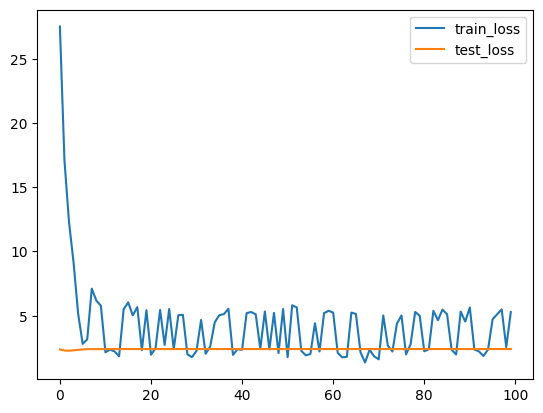

In [11]:

results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])